# Traveling Salesman Exploration

### Methods explored
* Brute force
* (Greedy) Genetic algorithm
* Nearest Neighbor (under construction)

Other ideas -> some uncrossing method...
more inspiration https://louisville.edu/speed/faculty/sheragu/Research/Intelligent/tsp.PDF

In [254]:
# not yet impletmented
# The optimal solution will always be a simple polygon
# to check that lists are not rotations of eachother, find the first 
# point that is equal to eachother, shift that to the first position and compare them
# uncross method, move to point closest to intersection??
# AMAZON - what if you are moving on a car and so your position is moving in a predictable (nested TSP?) way
# and the distances of travel vary with time?
# should i apply mutations to the best in each generation? -no?
# held and karp algorithm
# test accuracy with tsplib solutions? http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/index.html

In [71]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Random Point Creation

In [72]:
import random
import itertools

def generateUniquePoints(n, xrange, yrange):
    """
       Method for generating a list of n unique points
       bounded by x and y range.
    """
    if n > xrange*yrange:
        raise Exception("Cannot generate {0} unique points with given ranges. Not enough unique points in range.")
    
    # small optimization, use product of ranges for relatively large n (compared to product of ranges)
    # otherwise use a probablistic method of choosing random numbers and forcing them not to overlap
    if n > xrange*yrange*.5:
        xs, ys = range(0, xrange), range(0, yrange)
        points = itertools.product(xs, ys)
        return list(random.sample(list(points), n))
    else:
        points = set()
        while len(points) < n:
            points.add((random.randint(0, xrange), random.randint(0, yrange)))
        return list(points)

In [170]:
# generate 7 unique points with an x-range of 100 and y-range of 100
points = generateUniquePoints(100, 100, 100)

# Brute Force

In [74]:
import sys

def bruteForceTS(points):
    """
        Finds the path with minimum distance
        from given points. Do not do this with 
        more than 10 points. Even with 10 it will 
        take ~30 seconds
    """
    mindistance = 100000000000000 # a big number
    for x in list(itertools.permutations(points)):
        if evaluatePathDistance(x) < mindistance:
            mindistance = evaluatePathDistance(x)
            minpath = x
    return mindistance, minpath

# Genetic Algorithm

### The Basic Idea
* Create a population of random (unique) test paths/subjects
* Find n best subjects to "reproduce" by crossing over 
* Apply a random mutation to subjects in population
* Repeat for n generations

In [75]:
import copy

def createPopulation(n_subjects, points):
    """
        Creates a list of n random* sequences
        of points passed in.
    """
    population = []
    points = points
    for _ in range(0,n_subjects):
        random.shuffle(points)
        temp = points.copy()   # need to copy full list, can't reference
        population.append(temp)
    return population

# function does not check if the lists are unique, that means they aren't exactly the same
# AND that they are not just shifts of eachother (same path)

In [76]:
population = createPopulation(5, points)
# see what a population looks like
for x in population:
    print(x)

[(7, 15), (63, 55), (93, 43), (63, 0), (28, 80), (73, 56), (57, 52)]
[(73, 56), (7, 15), (63, 55), (93, 43), (57, 52), (28, 80), (63, 0)]
[(7, 15), (73, 56), (63, 0), (28, 80), (93, 43), (63, 55), (57, 52)]
[(63, 0), (63, 55), (7, 15), (28, 80), (73, 56), (93, 43), (57, 52)]
[(63, 55), (7, 15), (28, 80), (63, 0), (57, 52), (93, 43), (73, 56)]


In [77]:
def getLinks(ls):
    """
        Gets the all line segments from a sequence.
    """
    return [(x,ls[ix+1]) if (ix < len(ls)-1) else (x,ls[0]) for ix, x in enumerate(ls)]

In [78]:
import math

def evaluatePathDistance(path):
    """
        Iteratively get the sum of the distances
        between points in the path. Can I use reduce?
        This is essentially our fitness function...
        May add n crosses or something here
    """
    totalDistance = 0
    for ix, x in enumerate(path):
        if ix < len(path)-1:
            totalDistance += math.hypot(path[ix+1][0] - x[0], path[ix+1][1] - x[1])
        else:
            totalDistance += math.hypot(path[0][0] - x[0], path[0][1] - x[1])
    return totalDistance

In [79]:
def evaluateFitness(population):
    """ 
        The "Fitness Function" (for now) is essentially just that the most fit path is that
        with the shortest distance. Returns sorted list of most fit->least fit paths
    """
    return sorted(population, key=lambda path: evaluatePathDistance(path))

In [80]:
def greedyCrossover(population, drop=2):
    """
        What this crossover does is as follows:
        - Takes top 2 (or drop) shortest paths and drops the 2 lowest paths
        - Combines the top 2 parents to create 2 children
            - Get the "links" or line segements formed by the paths of the parents
            - Child 1: Alternating starting with parent 1 then parent 2 links
            - Child 2: Alternating starting with parent 2 then parent 1 links
            - If there is overlap during crossover...just randomly choose the rest of the links (ambiguous)
    """
    # get rid of the 2 worst subjects and make room for children
    # should I try not dropping them
    newPopulation = evaluateFitness(population)[:-drop]
    
    # the parents and their links
    parents = newPopulation[:2]
    parentLinks = [getLinks(x) for x in parents]

    children = []
    for c in range(0,2):  # assuming only 2 parents
        child = list(parentLinks[c][0])
        overlapGenRandom = False
        for x in range(0,len(parents[0][0])+1):  # go through the parents
            
            # check if there was overlap during crossover, to go the last part
            if overlapGenRandom:  
                break
           
            # x variable to shift make it switch between p1 and p2
            # during crossover, c used to switch starting parent
            if x+c % 2 == 0:
                # coor1 = line segment 1, coor2 = line segment 2
                for coor1,coor2 in parentLinks[1]:  # parent 2 
                    if coor1 == child[-1] and coor2 not in child:
                        child.append(coor2)
                        #print("p2")
                        break
            else:
                for coor1,coor2 in parentLinks[0]: # parent 1
                    if coor1 == child[-1] and coor2 not in child:
                        child.append(coor2)
                        break
        
        # check if the crossover was completed without overlaps
        remaining = set(parents[0]) - set(child)
        if len(remaining) > 0:
            while len(remaining) > 0:
                x = random.sample(set(remaining),1)[0]
                remaining.remove(x)
                child.append(x)
        children.append(child)
    return newPopulation+children

In [81]:
def applyMutation(population, chance):
    """
        Given a certain chance of mutation (per subject) 
        applies or doesn't apply a random mutation (point-swap)
        on each subject in the population"""
    length = len(population[0])
    mutatedPopulation = []
    for subject in population:
        # each subject has a "x" chance of mutating (swapping positions of 2 points)
        if random.random() < chance:
            i1, i2 = random.sample(range(0,length-1),2)
            subject[i1], subject[i2] = subject[i2], subject[i1] 
        mutatedPopulation.append(subject)
    return mutatedPopulation

In [171]:
def greedyGA(n_generations, points, population_size, mutation_perc_chance):
    """
        For n_generations, the population created from the given points will
        crossover traits and then with a certain chance, mutate or not.
    """
    population = createPopulation(population_size, points)
    min_distances = []
    min_distances.append(evaluatePathDistance(evaluateFitness(population)[0]))
    
    # collect stats? % improvement
    for _ in range(0,n_generations):
        population = greedyCrossover(population)
        population = applyMutation(population, mutation_perc_chance)
        min_distances.append(evaluatePathDistance(evaluateFitness(population)[0]))
        
    most_fit = evaluateFitness(population)[0]
    
    return evaluatePathDistance(most_fit), most_fit, min_distances

# Nearest Neighbor

### The Basic Idea
* Very simple algorithm, choose point at random.
* Find point closest to current point
* Make that point the current point
* Repeat until out of points

In [132]:
def nearestNeighbor(points):
    points = points.copy()
    length = len(points)
    nearestNeighbors = []
    
    curr = random.sample(points,1)[0] # sample and remove function..?
    points.remove(curr)
    nearestNeighbors.append(curr)
    
    while len(nearestNeighbors) < length:
        min_distance = 10000000000  # a large number...... int.max
        for ix, x in enumerate(points):
            distance_from_current = math.hypot(x[0] - curr[0], x[1] - curr[1])
            if distance_from_current < min_distance:
                min_distance, min_d_ix = distance_from_current, ix
        
        curr = points.pop(min_d_ix)
        nearestNeighbors.append(curr)
    return evaluatePathDistance(nearestNeighbors), nearestNeighbors

# Sorted Edges Algorithm

In [279]:
class Graph(object):

    def __init__(self, graph_dict={}):
        """ initializes a graph object """
        self.__graph_dict = graph_dict

    def vertices(self):
        """ returns the vertices of a graph """
        return list(self.__graph_dict.keys())
    
    def add_edge(self, edge):
        """ assumes that edge is of type set, tuple or list; 
            between two vertices can be multiple edges! 
        """
        edge = set(edge)
        (vertex1, vertex2) = tuple(edge)
        if vertex1 in self.__graph_dict:
            self.__graph_dict[vertex1].append(vertex2)
        else:
            self.__graph_dict[vertex1] = [vertex2]
    
    def plot(self, annotate=False):
        drawPath(self.vertices(), annotate=annotate, graph_type='scatter')
        #plt.scatter(*zip(*self.vertices()))
    
    def plot_all_edges(self):
        plt.plot(*zip(*itertools.chain(*sorted(itertools.combinations(self.vertices(),2), key=lambda edge: math.hypot(edge[1][0] - edge[0][0], edge[1][1] - edge[0][1])))))
    #def plot(self):

g = Graph()
for x in sorted(itertools.combinations(points,2), key=lambda edge: math.hypot(edge[1][0] - edge[0][0], edge[1][1] - edge[0][1])):
    g.add_edge(x)
print(g.vertices())

[(85, 18), (32, 64), (47, 23), (32, 15), (64, 89), (56, 69), (33, 78), (70, 57), (49, 1), (13, 69), (64, 57), (42, 21), (94, 48), (14, 33), (90, 70), (55, 13), (69, 98), (84, 78), (98, 45)]


In [ ]:


def sortedEdges(points):
    # edges sorted by distance
    edges = sorted(itertools.combinations(points,2), key=lambda edge: math.hypot(edge[1][0] - edge[0][0], edge[1][1] - edge[0][1]))
    
    curr = edges[0]
    

In [197]:
for x in sorted(itertools.combinations(points,2), key=lambda edge: math.hypot(edge[1][0] - edge[0][0], edge[1][1] - edge[0][1])):
    print(x, math.hypot(x[1][0] - x[0][0], x[1][1] - x[0][1]))

((4, 6), (5, 6)) 1.0
((78, 26), (79, 26)) 1.0
((9, 7), (8, 8)) 1.4142135623730951
((8, 8), (9, 9)) 1.4142135623730951
((4, 71), (3, 72)) 1.4142135623730951
((48, 38), (49, 37)) 1.4142135623730951
((9, 7), (9, 9)) 2.0
((48, 32), (50, 32)) 2.0
((53, 99), (51, 100)) 2.23606797749979
((36, 45), (34, 44)) 2.23606797749979
((58, 87), (57, 89)) 2.23606797749979
((54, 85), (52, 83)) 2.8284271247461903
((76, 90), (76, 87)) 3.0
((96, 49), (93, 50)) 3.1622776601683795
((29, 59), (26, 60)) 3.1622776601683795
((16, 34), (19, 33)) 3.1622776601683795
((4, 55), (3, 58)) 3.1622776601683795
((79, 89), (76, 90)) 3.1622776601683795
((76, 90), (77, 93)) 3.1622776601683795
((66, 20), (63, 19)) 3.1622776601683795
((58, 87), (59, 84)) 3.1622776601683795
((8, 8), (5, 6)) 3.605551275463989
((79, 89), (76, 87)) 3.605551275463989
((57, 43), (55, 40)) 3.605551275463989
((23, 62), (26, 60)) 3.605551275463989
((99, 81), (96, 83)) 3.605551275463989
((73, 20), (75, 23)) 3.605551275463989
((55, 81), (52, 83)) 3.6055512

In [193]:
#test = generateUniquePoints(10,10,20)
print(test)
for x in itertools.combinations(test, 2):
    print(x)

[(2, 16), (2, 6), (4, 18), (0, 17), (8, 19), (3, 9), (0, 5), (3, 19), (1, 10), (9, 12)]
((2, 16), (2, 6))
((2, 16), (4, 18))
((2, 16), (0, 17))
((2, 16), (8, 19))
((2, 16), (3, 9))
((2, 16), (0, 5))
((2, 16), (3, 19))
((2, 16), (1, 10))
((2, 16), (9, 12))
((2, 6), (4, 18))
((2, 6), (0, 17))
((2, 6), (8, 19))
((2, 6), (3, 9))
((2, 6), (0, 5))
((2, 6), (3, 19))
((2, 6), (1, 10))
((2, 6), (9, 12))
((4, 18), (0, 17))
((4, 18), (8, 19))
((4, 18), (3, 9))
((4, 18), (0, 5))
((4, 18), (3, 19))
((4, 18), (1, 10))
((4, 18), (9, 12))
((0, 17), (8, 19))
((0, 17), (3, 9))
((0, 17), (0, 5))
((0, 17), (3, 19))
((0, 17), (1, 10))
((0, 17), (9, 12))
((8, 19), (3, 9))
((8, 19), (0, 5))
((8, 19), (3, 19))
((8, 19), (1, 10))
((8, 19), (9, 12))
((3, 9), (0, 5))
((3, 9), (3, 19))
((3, 9), (1, 10))
((3, 9), (9, 12))
((0, 5), (3, 19))
((0, 5), (1, 10))
((0, 5), (9, 12))
((3, 19), (1, 10))
((3, 19), (9, 12))
((1, 10), (9, 12))


# Graphing Stuff Now

In [83]:
def drawPath(points, annotate=False, graph_type='line'):
    """
        Creates a graph of the points
        and optionally annotates it with
        the cartesian coordinates.
    """
    xs, ys = zip(*points)
    xs, ys = list(xs), list(ys)
    xs.append(xs[0])
    ys.append(ys[0])
    fig = plt.figure()
    ax = plt.subplot(111)
    
    if graph_type == 'line':
        plt.plot(xs,ys)
    elif graph_type == 'scatter':
        plt.scatter(xs,ys)
    
    if annotate:
        for xy in zip(xs, ys):                                      
            ax.annotate('(%s, %s)' % xy, xy=xy)  # thank you stack overflow

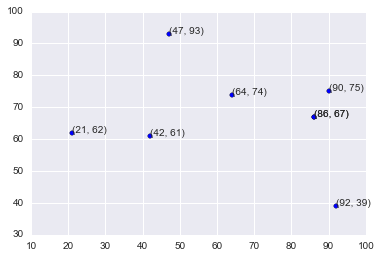

In [247]:
drawPath(points, annotate=True, graph_type='scatter')

205.20388909193824


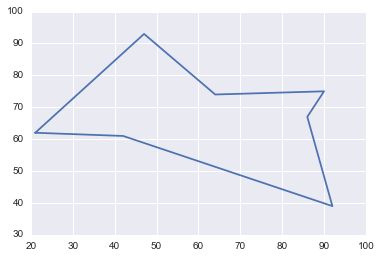

In [248]:
mindistance, minpath = bruteForceTS(points)
print(mindistance)
drawPath(list(minpath))

872.6811076773882


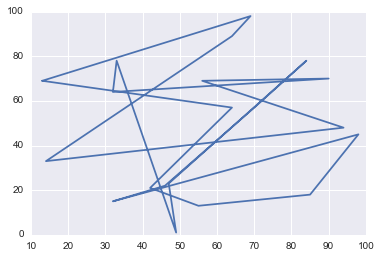

In [257]:
n_generations = 100
population_size = 10
mutation_percentage_chance = 4

min_ga_dist, min_ga_path, min_ga_distances = greedyGA(n_generations, points, population_size, mutation_percentage_chance)

print(min_ga_dist)
drawPath(min_ga_path)

380.8057484999431


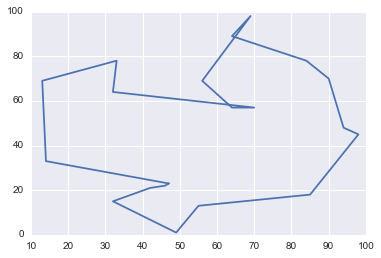

In [258]:
min_nn_distance, min_nn_path = nearestNeighbor(points)
print(min_nn_distance)

drawPath(min_nn_path)

# Line Segment Intersection

In [87]:
# converted to python from 
# http://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect

def doLineSegmentsIntersect(p, p2, q, q2):
    """
        Method for testing wheter or not line segments 
        from p-p2 and q-q2 intersect. I do not fully understand thi
        at the moment. Looking to talk with Prof Buskin.
    """
    r = subtractPoints(p2, p)
    s = subtractPoints(q2, q)
    
    uNumerator = crossProduct(subtractPoints(q, p), r)
    denominator = crossProduct(r, s)

    if (uNumerator == 0 and denominator == 0):
        # They are coLlinear

        # Do they touch? (Are any of the points equal?)
        if (equalPoints(p, q) or equalPoints(p, q2) or equalPoints(p2, q) or equalPoints(p2, q2)):
            return True
        
        # Do they overlap? (Are all the point differences in either direction the same sign)
        # Using != as exclusive or
        return ((q[0] - p[0] < 0) != (q[0] - p2[0] < 0) != (q2[0] - p[0] < 0) != (q2[0] - p2[0] < 0)) or ((q[1] - p[1] < 0) != (q[1] - p2[1] < 0) != (q2[1] - p[1] < 0) != (q2[1] - p2[1] < 0))

    if (denominator == 0):
        # lines are paralell
        return False

    u = uNumerator / denominator
    t = crossProduct(subtractPoints(q, p), s) / denominator

    return (t > 0) and (t < 1) and (u > 0) and (u < 1)  # had problems when line segments overlap on 1 point 



def crossProduct(point1, point2):
    return point1[0] * point2[1] - point1[1] * point2[0]



def subtractPoints(point1, point2): 
    return (point1[0] - point2[0], point1[1] - point2[1])


def equalPoints(point1, point2):
    return (point1[0] == point2[1]) and (point1[1] == point2[1])

In [88]:
def getPathCrosses(path):
    """
        Given a path, this functions returns the number of line crosses are
        in the path. (not sure if this works....need to test further)
    """
    count = 0
    links = getLinks(path)
    for ix,(a,b) in enumerate(links):
        for x in range(ix+1, len(links)):
            if x < len(links)-1:
                if doLineSegmentsIntersect(a,b,links[x][0],links[x][1]):
                    count += 1
            else:
                if doLineSegmentsIntersect(a,b,links[0][0],links[0][1]):
                    count += 1
    return count

In [89]:
# Number of crosses in the optimal path calculated
# from the brute force method
getPathCrosses(minpath)

# The solution to the TSP will always be a simple polygon (no line crosses)
# http://www.ams.org/samplings/feature-column/fcarc-tsp

0

In [90]:
getPathCrosses(min_ga_path)

0

In [255]:
points = generateUniquePoints(20,100,100)

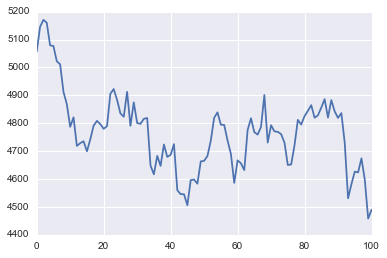

In [182]:
plt.plot(*zip(*[(x,y) for x,y in enumerate(min_ga_distances)]))

In [147]:
mindistance

293.40781229745437

In [159]:
min_ga_distances

[359.1601369960655,
 310.21111824052116,
 327.779480977483,
 320.7304749093377,
 300.24877632299814,
 327.5184197719829,
 325.95025101278765,
 321.1640466207055,
 390.48260352259564,
 383.459231626361,
 327.51841977198296,
 404.75216569763217,
 414.5468257394355,
 303.3701542149774,
 320.72616952631245,
 306.9008046122651,
 296.1246921209737,
 371.1087080029865,
 332.9876710641897,
 303.3701542149774,
 321.1640466207055,
 303.3701542149774,
 362.9712906671336,
 345.3542141502985,
 362.97129066713364,
 373.1265882112606,
 356.61691751585624,
 293.40781229745437,
 352.49283331383185,
 329.3375187404151,
 333.17632130776843,
 416.7644403846951,
 374.59655883594337,
 296.1246921209737,
 345.3542141502985,
 359.1601369960655,
 293.4078122974544,
 306.9008046122651,
 296.12469212097375,
 309.950057035021,
 296.12469212097375,
 303.5956838837437,
 317.12903636543626,
 300.2487763229981,
 325.95025101278765,
 310.21111824052116,
 408.8762498996566,
 363.0231599925898,
 320.7304749093377,
 366.

In [200]:
test = [(99, 39),
 (96, 49),
 (88, 10),
 (43, 99)]

In [204]:
ls1 = ((99, 39),(96, 49))
ls2 = ((88, 10),(43, 99))

In [206]:
ls1[1][1]-ls1[0][1]/ls1[1][0]-ls1[0][0],

(-50.40625,)

In [207]:
ls2[1][1]-ls2[0][1]/ls2[1][0]-ls2[0][0],

(10.767441860465112,)

In [ ]:
(y-39) = 50.4(x-99)

In [208]:
xdiff = (ls1[0][0] - ls1[1][0], ls2[0][0] - ls2[1][0])
ydiff = (ls1[0][1] - ls1[1][1], ls2[0][1] - ls2[1][1]) #Typo was here

def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

det(xdiff,ydiff)

183

In [252]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return False

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return (min([line1[0][0],line1[1][0]]) < x < max([line1[0][0],line1[1][0]])) and \
           (min([line2[0][1],line2[1][1]]) < y < max([line2[0][1],line2[1][1]]))

In [213]:
x in range(sorted([line1[0],line2[0]]))

(136.44262295081967,
 -85.80874316939891,
 ((99, 39), (96, 49)),
 ((88, 10), (43, 99)))

In [214]:
doLineSegmentsIntersect((99, 39),(96, 49),(88, 10), (43, 99))

False

In [240]:
line_intersection(ls1,ls2)

False

In [243]:
def testPathCrosses(path):
    """
        Given a path, this functions returns the number of line crosses are
        in the path. (not sure if this works....need to test further)
    """
    count = 0
    links = getLinks(path)
    for ix,(a,b) in enumerate(links):
        for x in range(ix+1, len(links)):
            if x < len(links)-1:
                print(doLineSegmentsIntersect(a,b,links[x][0],links[x][1]),line_intersection((a,b),(links[x][0],links[x][1])))
            else:
                print(doLineSegmentsIntersect(a,b,links[0][0],links[0][1]),line_intersection((a,b),(links[0][0],links[0][1])))
    return count

In [234]:
96 < 136.44262295081967 < 99

False

In [235]:
136.44262295081967 between 96 and 99

SyntaxError: invalid syntax (<ipython-input-235-5c8ab82fb824>, line 1)

In [259]:
testPathCrosses(min_nn_path)

False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
Fals

0

In [260]:
x = {(1,2):(3,4)}

In [261]:
x

{(1, 2): (3, 4)}

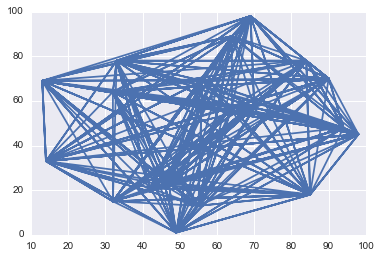

In [268]:
#g = Graph()
#for p1,p2 in sorted(itertools.combinations(points,2), key=lambda edge: math.hypot(edge[1][0] - edge[0][0], edge[1][1] - edge[0][1])):
#    g.add_edge(x)
#print(g.vertices())

#xs, ys = zip(*itertools.chain(*sorted(itertools.combinations(points,2), key=lambda edge: math.hypot(edge[1][0] - edge[0][0], edge[1][1] - edge[0][1]))))
plt.plot(*zip(*itertools.chain(*sorted(itertools.combinations(points,2), key=lambda edge: math.hypot(edge[1][0] - edge[0][0], edge[1][1] - edge[0][1])))))

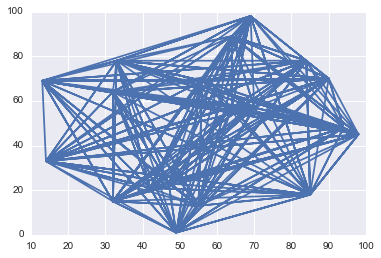

In [273]:
g.plot_all_edges()

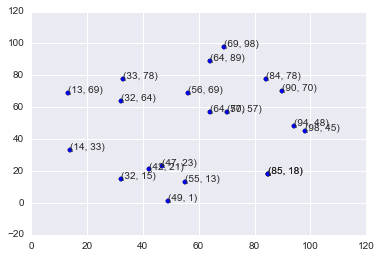

In [282]:
g.plot(annotate=True)